In [4]:
import numpy as np
import scipy as sp
import os 
import sys
import importlib

In [5]:
util_path = 'C:/ASM/Dropbox/Developments/Jupyter/Eating/myutils' if 'C:' in os.getcwd() else './myutils'
sys.path.append(util_path)
import my_file_utils as mfileu
import my_steven_free_utils as msfreeu
import my_classification_utils as mcu
#importlib.reload(mdu)

In [23]:
annots = mfileu.read_file('data', 'free_data_steven_annots.pkl')
lab_data = mfileu.read_file('data', 'lab_data_steven.pkl')
free_data = mfileu.read_file('data', 'free_data_steven_right.pkl')

In [54]:
def find_events(proba):
    count = len(proba)
    th = np.percentile(proba, 99.9)
    #print("Count, Threshold: ", count, th)
    #print(np.sum(proba>th))
    
    res =[]
    inside = False
    for i in range(count):
        if proba[i]>=th and inside==False:
            inside = True
            si = i
        elif proba[i]<th/2 and inside==True:            
            res.append([si, i-1])
            inside = False
    
    res = np.array(res)    
    res = np.mean(res, axis=1).astype(int)
    return res

def lab_bite_metric(a, ix, offset):
    a = a[(a[:, 2]==1) & (a[:, 3]!=2), 0]
    
    tp, fp, fn = 0, 0, 0
    
    for i in range(len(a)):
        if np.sum((ix-offset<=a[i]) &(a[i]<=ix+offset))>0:
            tp += 1
        else:
            fn+=1
    
    for i in range(len(ix)):
        if np.sum((a-offset<=ix[i]) &(ix[i]<=a+offset))==0:
            fp += 1
        
    return tp, fp, fn

tps, fps, fns = 0, 0, 0
for subj in range(len(lab_data)):
    for sess in range(len(lab_data[subj])):
        print("Subj, sess: ", subj, sess)
        
        a = lab_data[subj][sess]["annots"]
        res = mfileu.read_file('baseline_test_results', 'bite_lab_'+str(subj)+'_'+str(sess)+".pkl")
        
        indices = res[:, 0]+40
        p = res[:, -1]
        
        b = find_events(p)
        #print(np.amax(b[:,1]-b[:, 0]))
        #b = np.mean(b, axis=1).astype(int)
        ix = indices[b]
        
        tp, fp, fn = lab_bite_metric(a, ix, offset=8)
        #print("TP, FP, FN: ", tp, fp, fn)
        
        tps+=tp
        fps+=fp
        fns+=fn
print("TPs, FPs, FNs: ", tps, fps, fns)
pc = tps/(tps+fps)
rc = tps/(tps+fns)
print(pc, rc)

In [75]:
def cluster_events(meal_events, bites):        
    me = np.zeros((len(meal_events), 2))
    me[:, 0] = meal_events
    me[:, 1] = 1
    
    e = me    
    if len(bites)>0:        
        be = np.zeros((len(bites), 2))
        be[:, 0] = bites
        be[:, 1] = 2    
        e = np.concatenate((me, be))
        ix = np.argsort(e[:, 0])
        e = e[ix, :]       
    
    e = e.astype(int)    
    indices = e[:, 0]
    bm = e[:, 1]
    #print(len(bm), np.sum(bm==1), np.sum(bm==2))
    
    count = len(indices)
    clusters = []
    c = [0]
    for i in range(1, count):
        if  indices[i] - indices[c[-1]]<=16*60:
            c.append(i)
        else:
            si = indices[c[0]]
            ei = indices[c[-1]]
            mc = np.sum(bm[c[0]:c[-1]+1]==1)
            bc = np.sum(bm[c[0]:c[-1]+1]==2)
            
            clusters.append([si, ei, mc, bc])
            #print(len(c), mc, bc)
            assert len(c) == mc+bc
            c=[i]
    
    
    si = indices[c[0]]
    ei = indices[c[-1]]
    mc = np.sum(bm[c[0]:c[-1]+1]==1)
    bc = np.sum(bm[c[0]:c[-1]+1]==2)
    clusters.append([si, ei, mc, bc])
    assert len(c) == mc+bc
    
    return np.array(clusters)
    

Subj, sess:  0 0


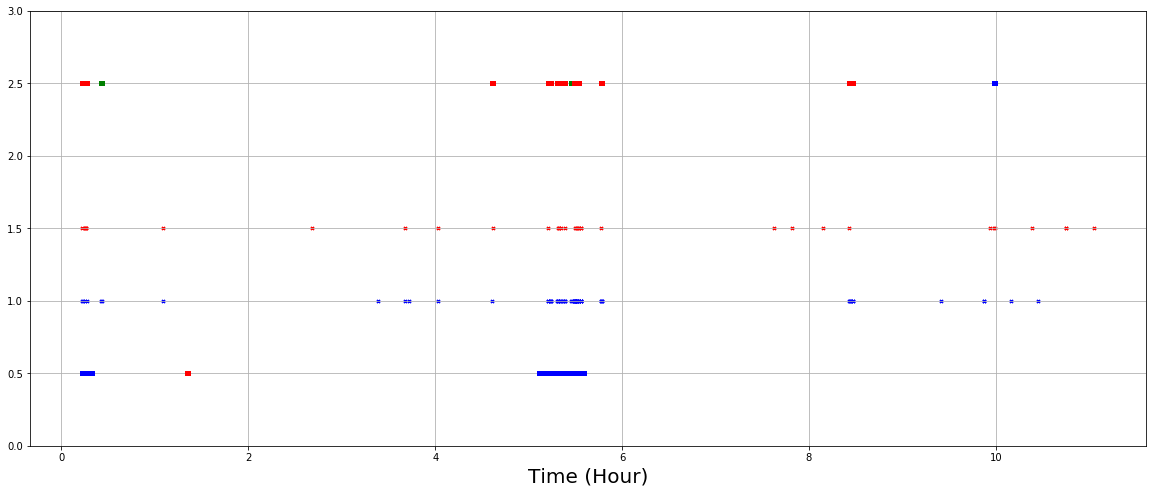

Subj, sess:  0 1


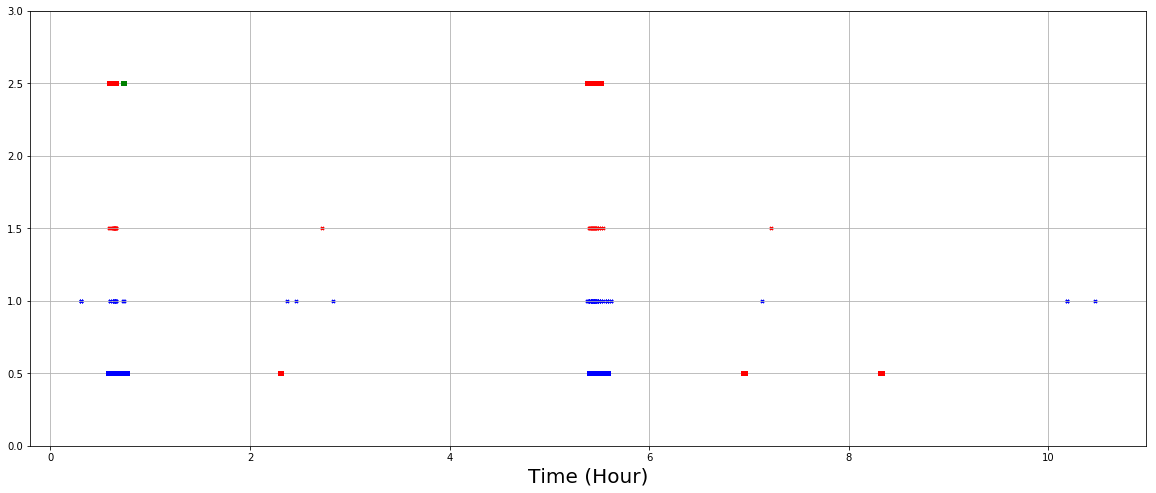

Subj, sess:  1 0


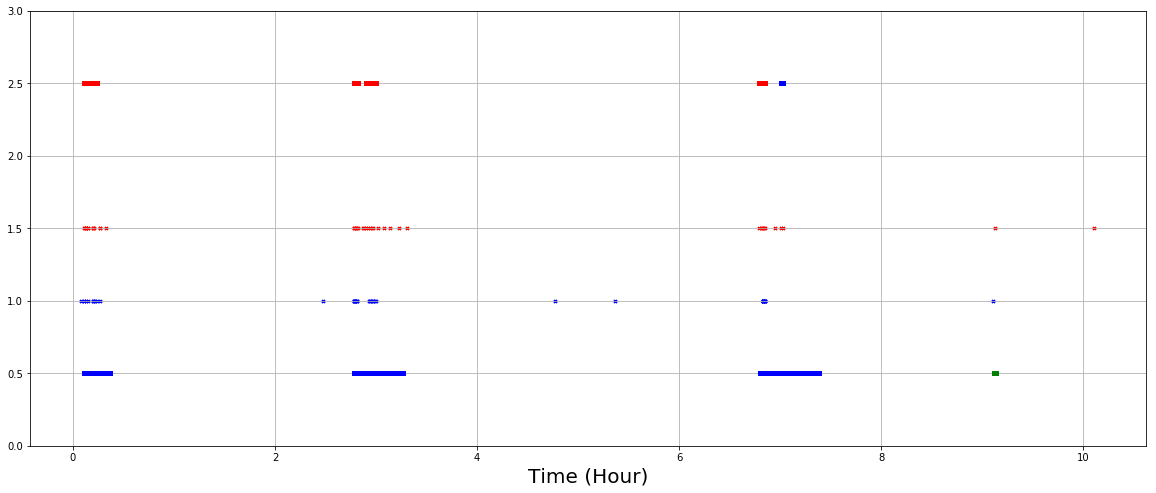

Subj, sess:  1 1


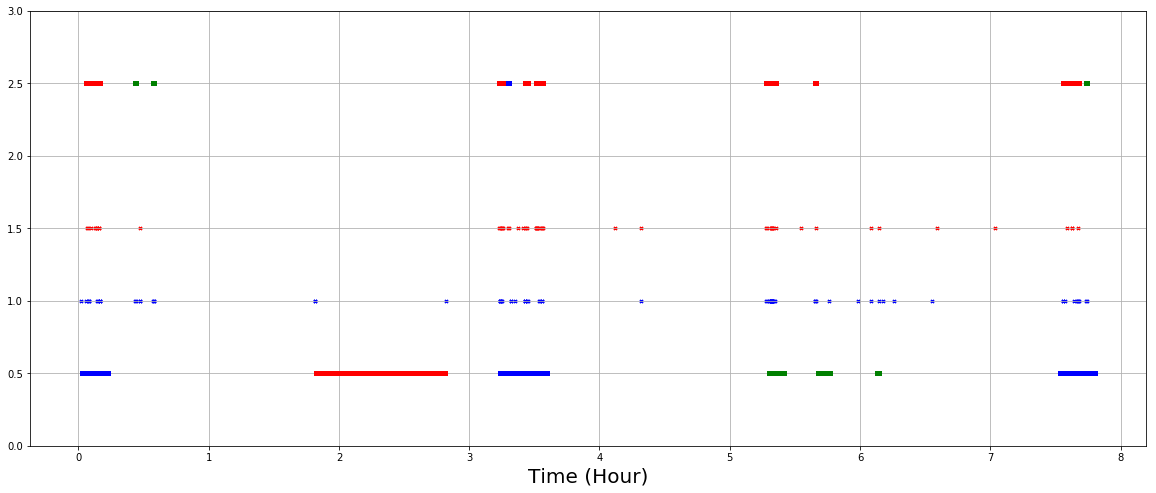

Subj, sess:  2 0


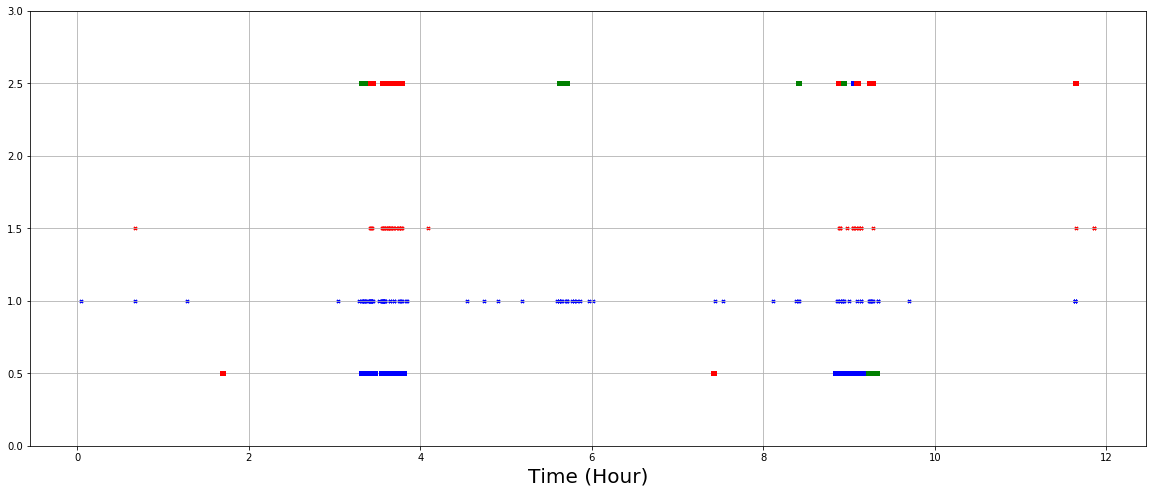

Subj, sess:  2 1


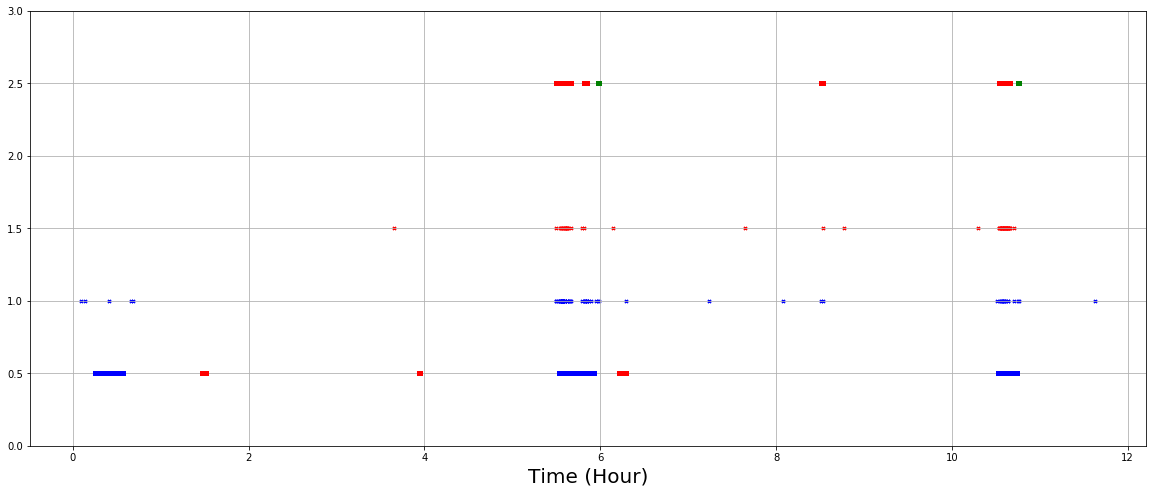

Subj, sess:  3 0
Annots cut at meal: 10/11, Times data, start: 25196, 27602


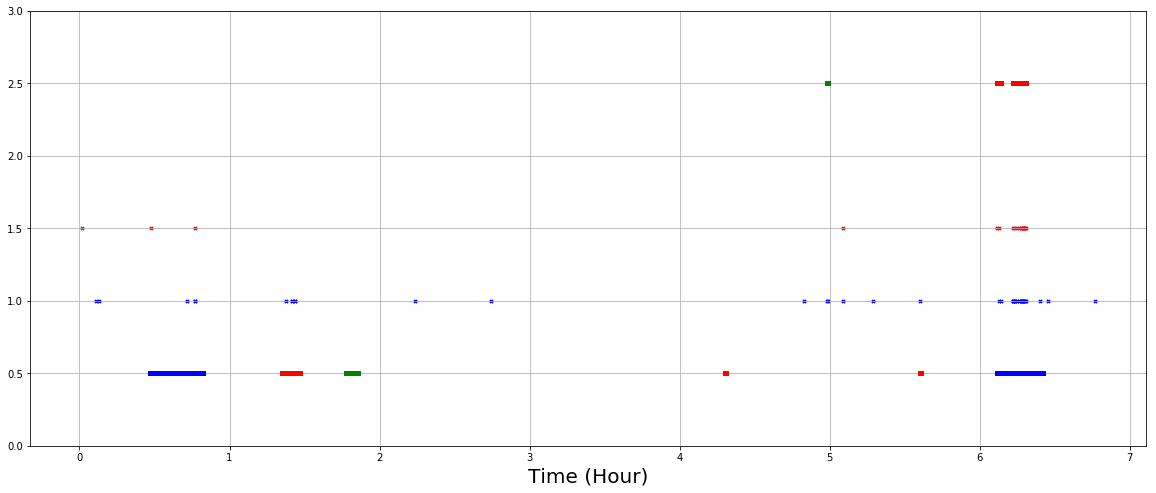

Subj, sess:  3 1


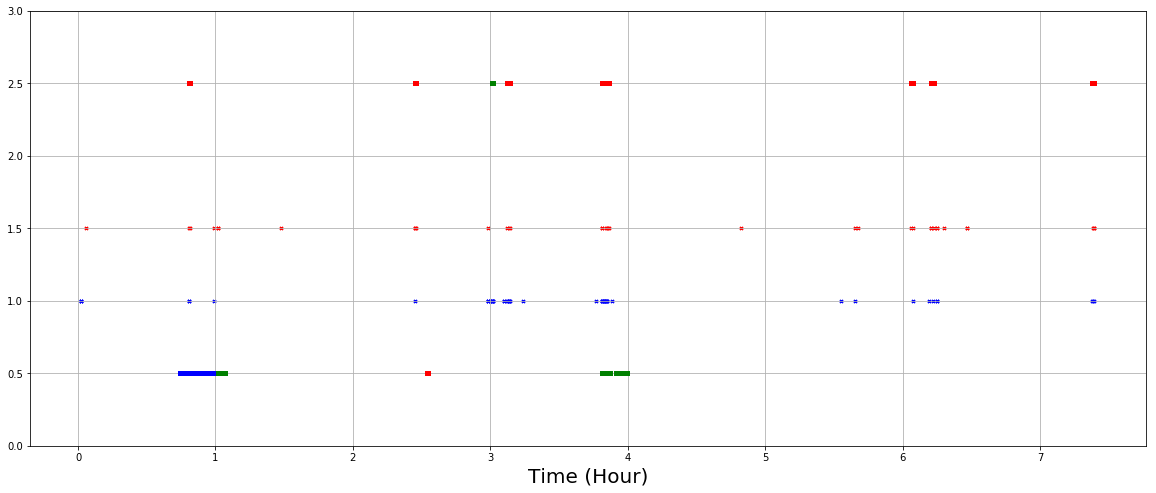

Subj, sess:  4 0
Annots cut at meal: 3/3, Times data, start: 30691, 31240


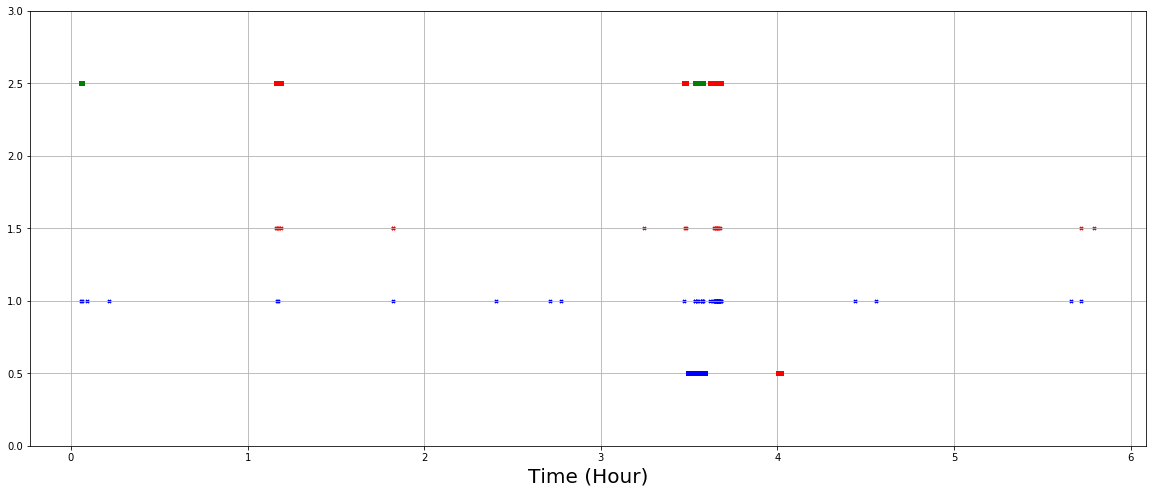

Subj, sess:  4 1


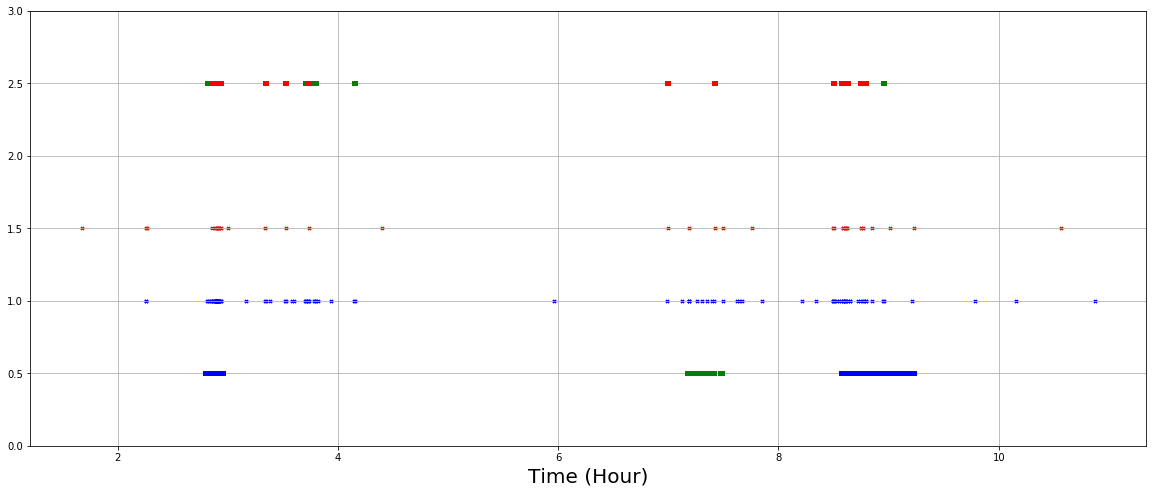

Subj, sess:  5 0


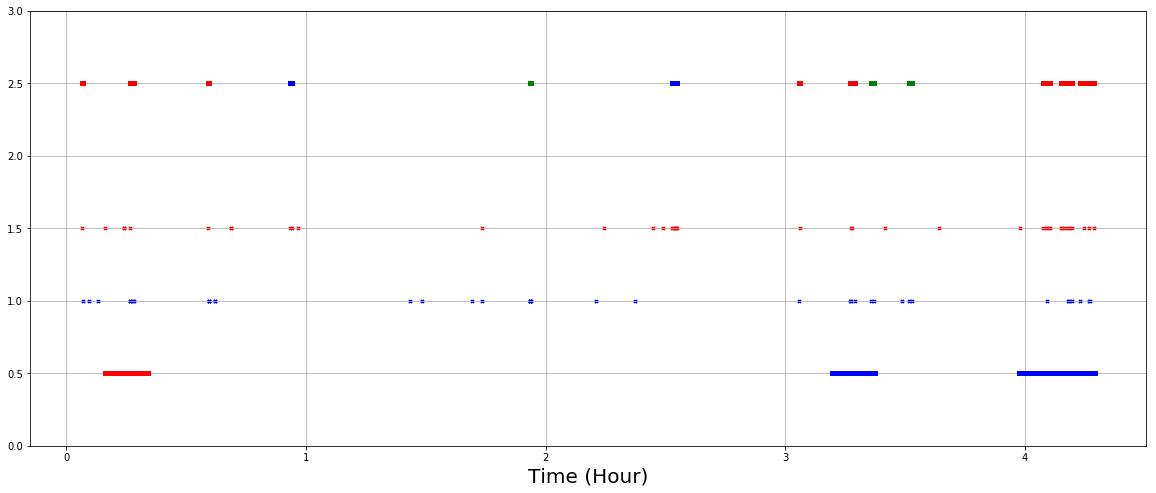

Subj, sess:  5 1


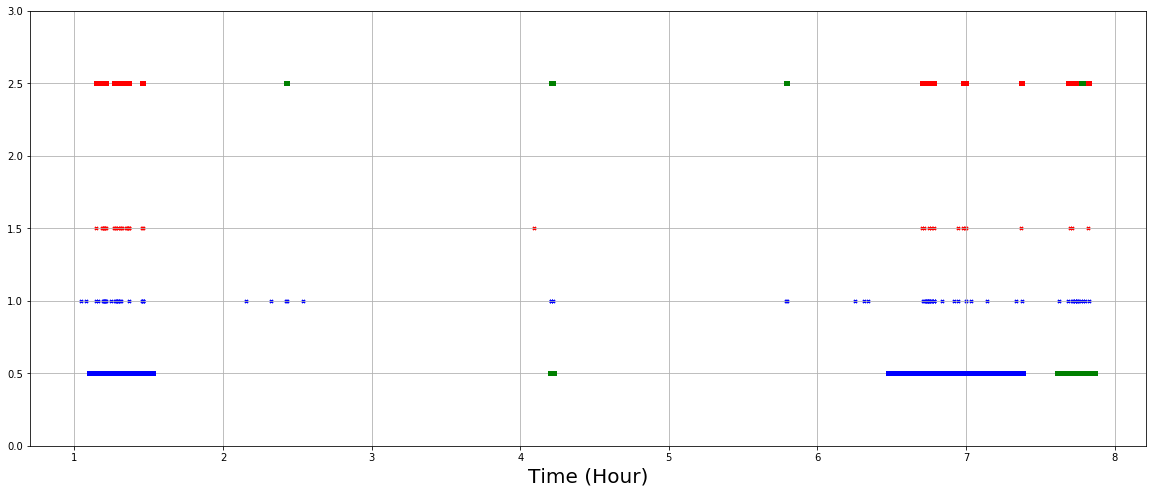

Subj, sess:  6 0


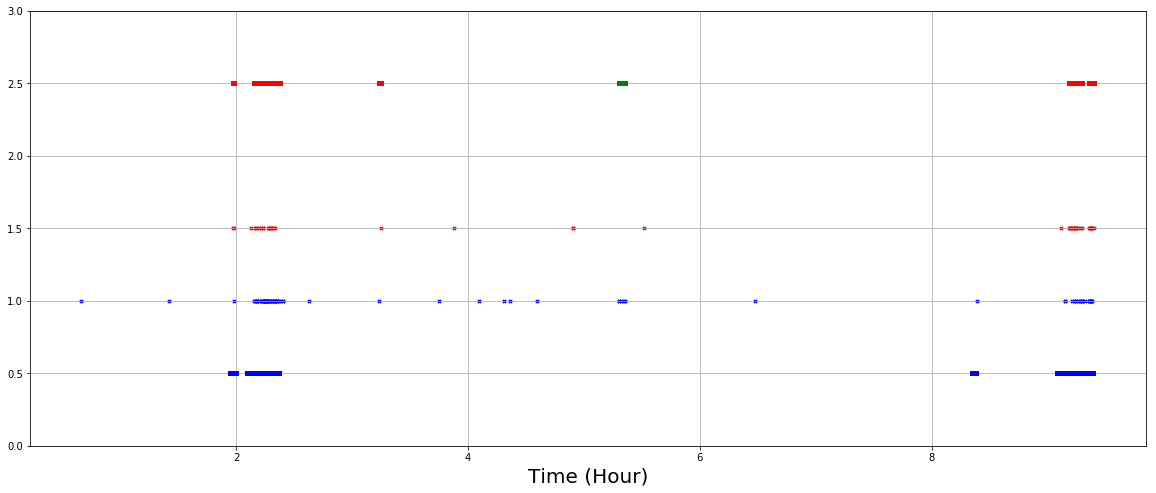

Subj, sess:  6 1
Annots cut at meal: 2/2, Times data, start: 27208, 27292


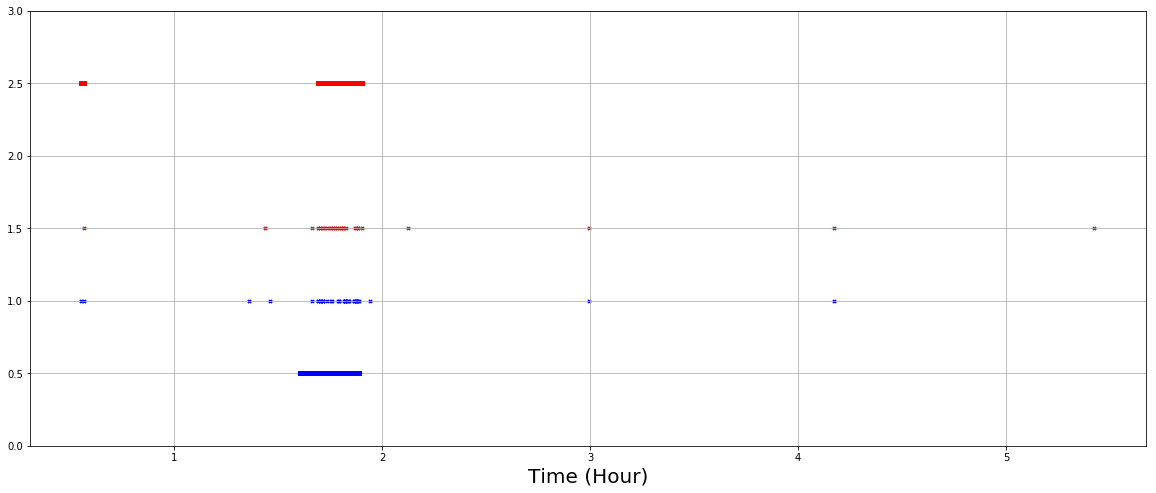

Subj, sess:  7 0


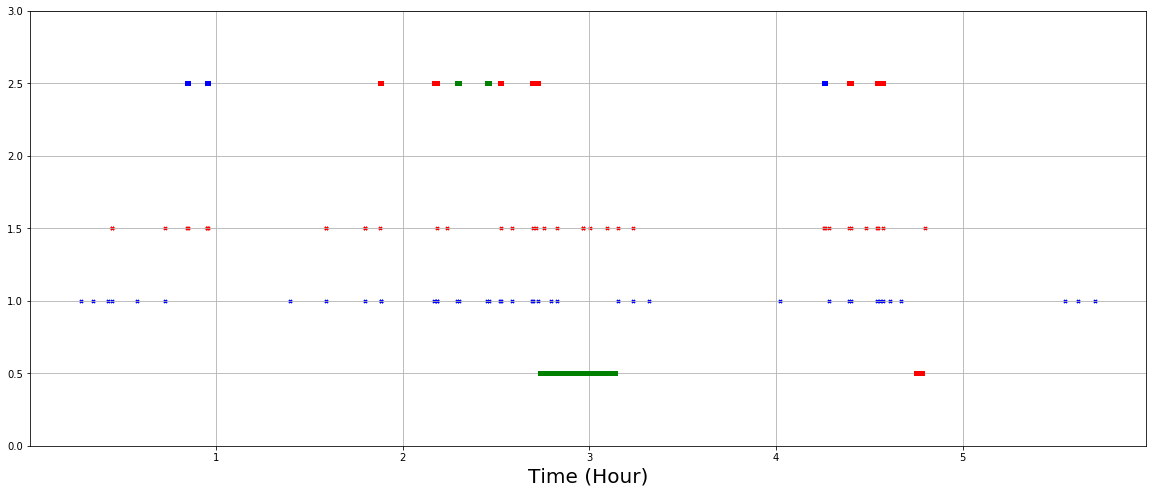

Subj, sess:  7 1


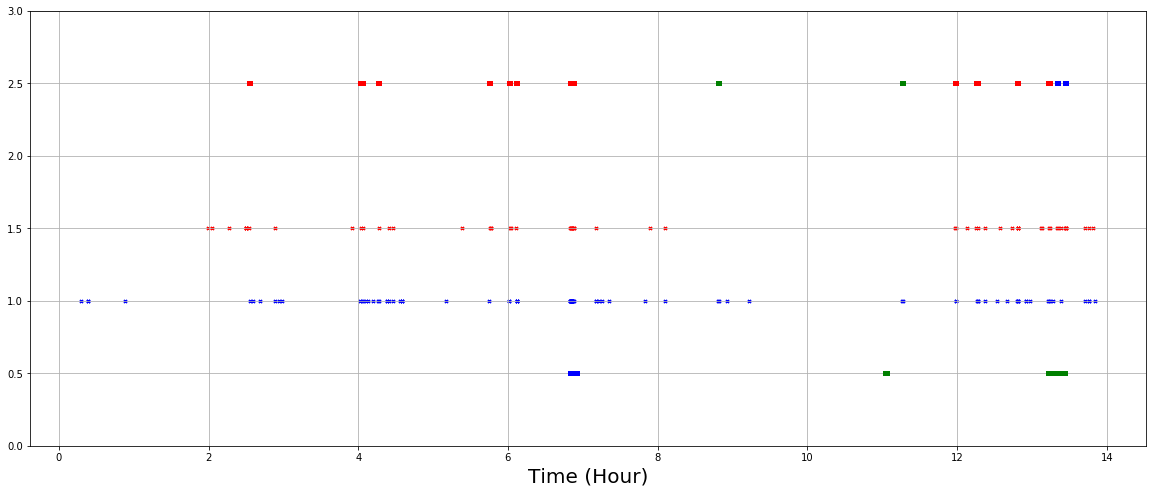

Subj, sess:  8 0
Annots cut at meal: 8/8, Times data, start: 38377, 38991


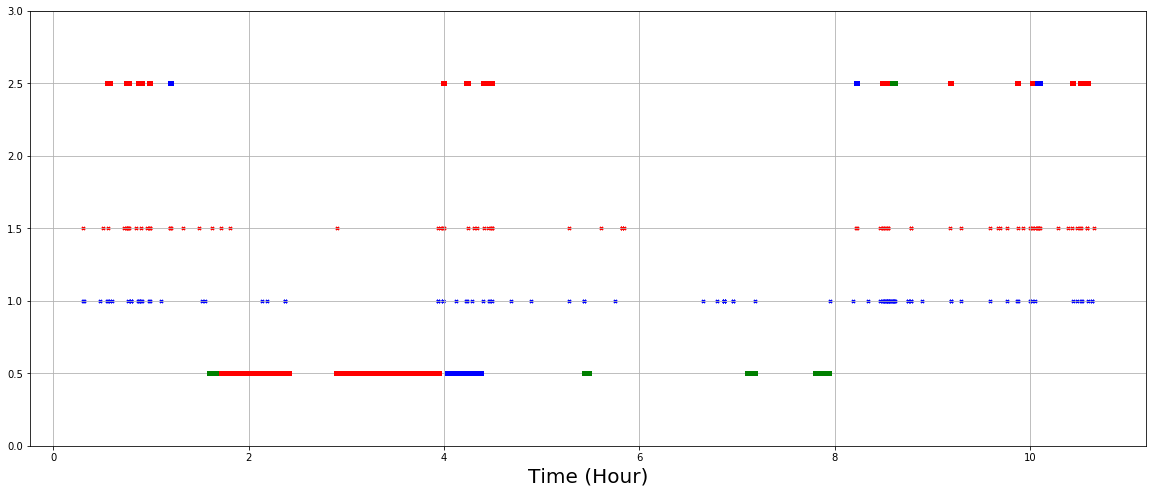

Subj, sess:  8 1


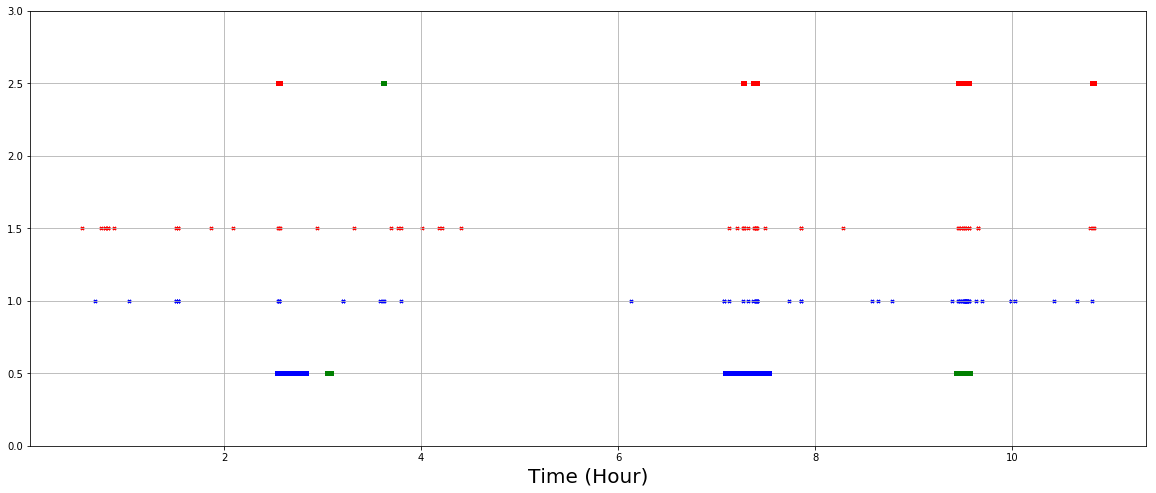

Subj, sess:  9 0


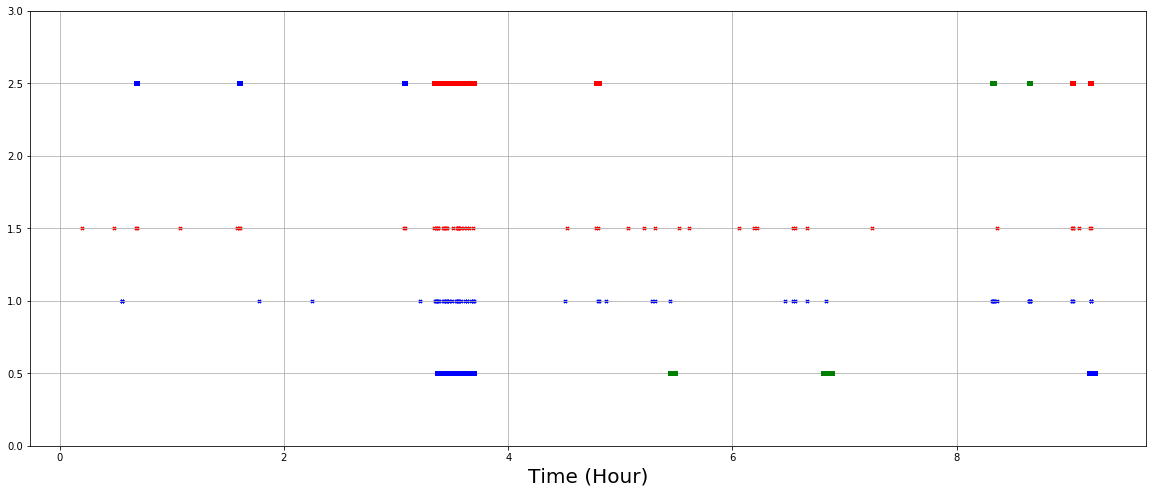

Subj, sess:  9 1


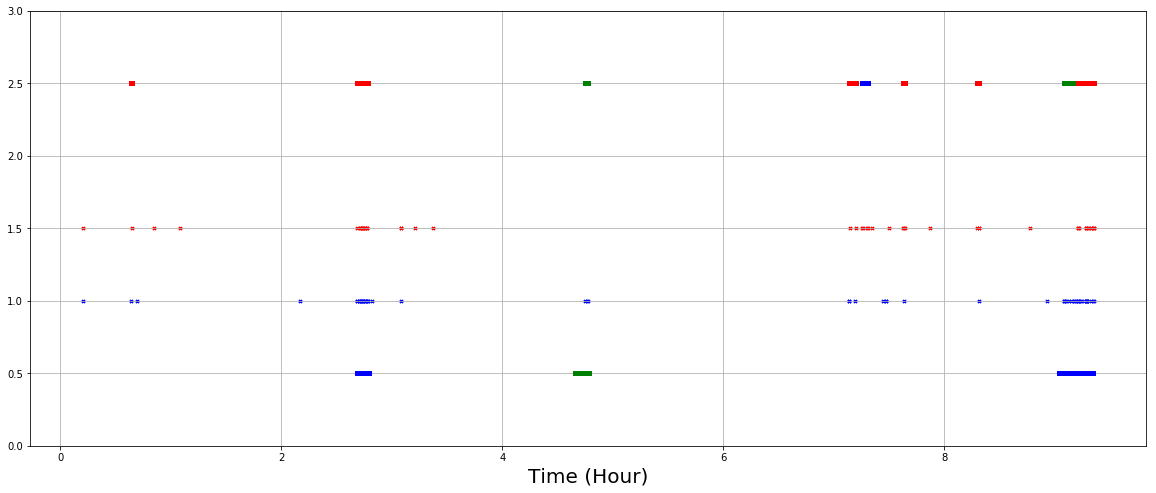

Subj, sess:  9 2


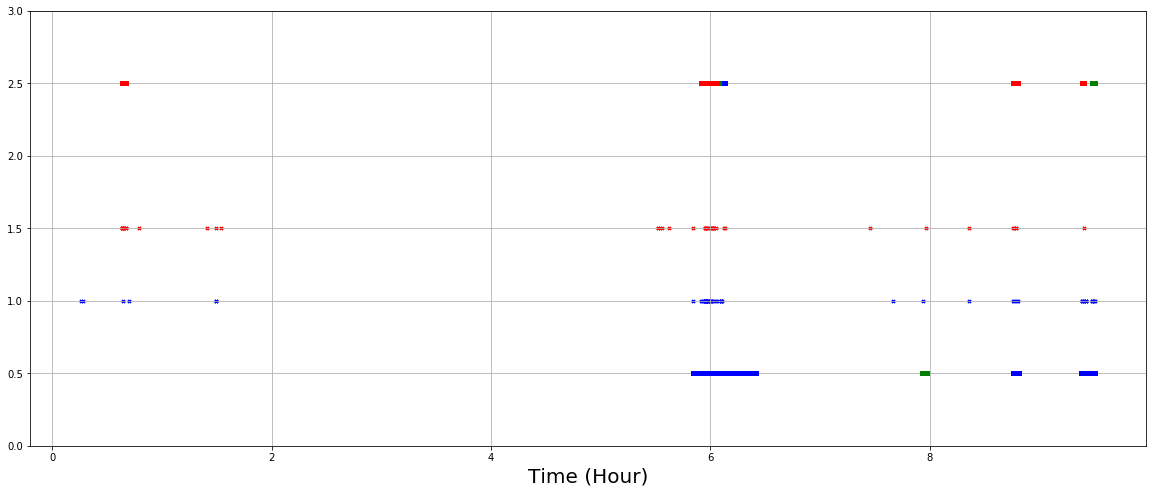

Subj, sess:  9 3


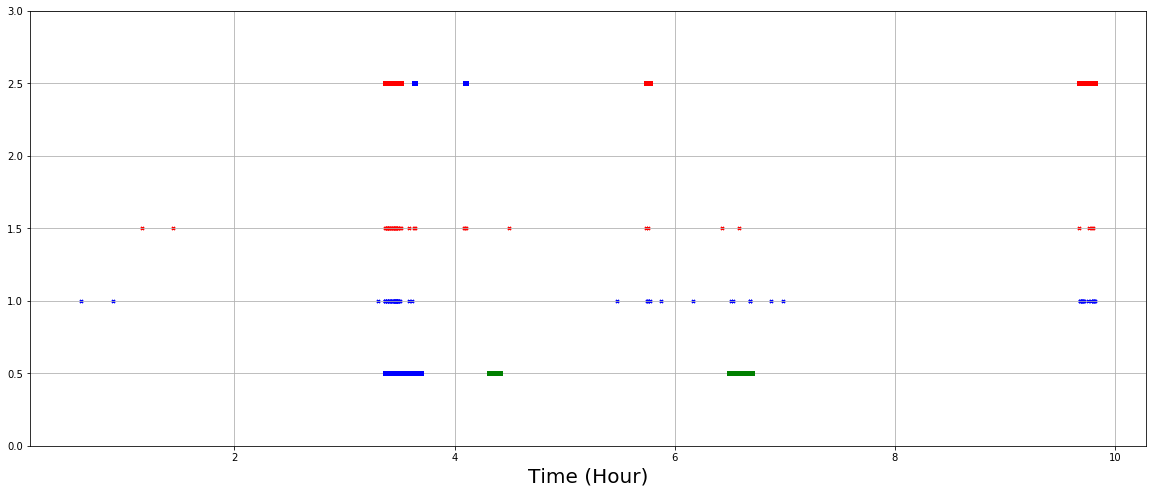

Subj, sess:  9 4


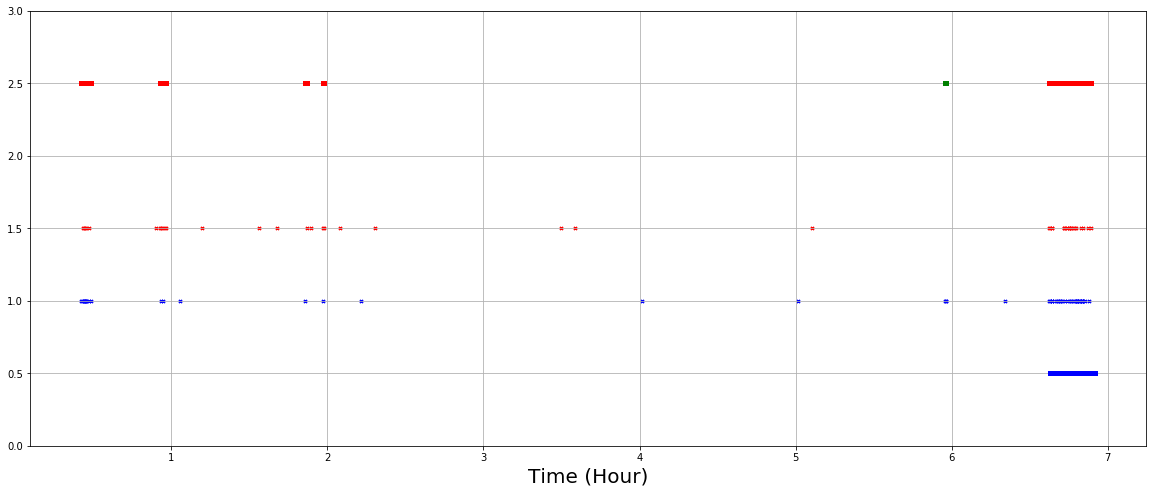

Subj, sess:  10 0


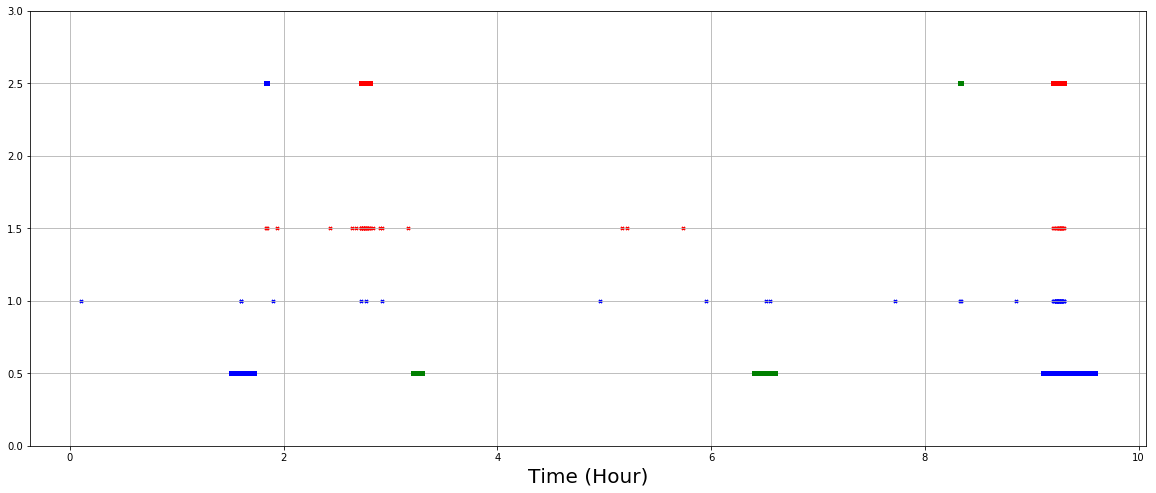

Subj, sess:  10 1


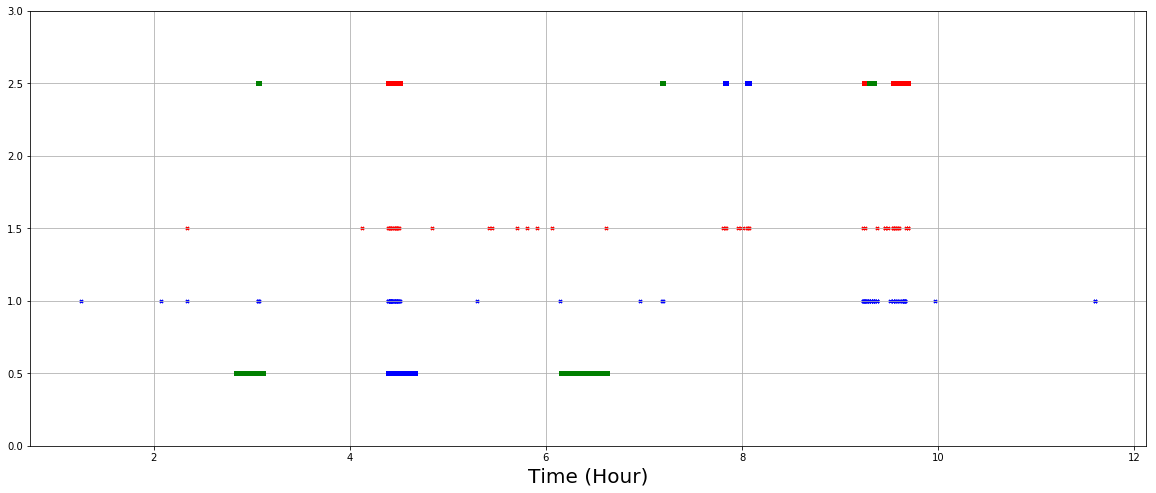

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline

idf = 16*60*60
for subj in range(len(annots)):
    for sess in range(len(annots[subj])):
        print("Subj, sess: ", subj, sess)
        
        a = annots[subj][sess]        
        a = msfreeu.process_anntos(len(free_data[subj][sess]), a)
        
        res = mfileu.read_file('baseline_test_results', 'bite_free_'+str(subj)+'_'+str(sess)+".pkl")
        indices = res[:, 0]+40
        p = res[:, -1]        
        bite_ix = find_events(p)
        bite_ix = indices[bite_ix]
        
        res = mfileu.read_file('baseline_test_results', 'meal_free_'+str(subj)+'_'+str(sess)+".pkl")
        assert len(indices) == len(res)
        indices = res[:, 0]+40
        p = res[:, -1]        
        meal_ix = find_events(p)
        meal_ix = indices[meal_ix]
        
        clusters = cluster_events(meal_ix, bite_ix)
        
        ###############################################
        
        fig = plt.figure(figsize=(20,8))
        ax = plt.subplot(111)        
        ax.scatter(bite_ix/idf, np.zeros((len(bite_ix)),)+1, marker='x', s=10, color='blue')                
        ax.scatter(meal_ix/idf, np.zeros((len(meal_ix),))+1.5, marker='x', s=10, color='red')                
                
        clrs = ['', 'blue', 'green', 'red', 'black']
        for i in range(len(a)):
            si = a[i, 0]/idf
            ei = a[i, 1]/idf
            mt = a[i, 2]            
            ax.plot([si, ei], [0.5, 0.5], color=clrs[mt], linewidth=5)
        
        for i in range(len(clusters)):
            si = clusters[i, 0]/idf
            ei = clusters[i, 1]/idf
            
            mt = 3
            if clusters[i, 2]==0:
                mt = 2
            elif clusters[i, 3]==0:
                mt = 1
            
            ax.plot([si, ei], [2.5, 2.5], color=clrs[mt], linewidth=5)
                
        
        plt.xlabel('Time (Hour)', fontsize=20)        
        plt.ylim([0, 3])
        plt.grid(True)
        plt.show()
        
        